# Analysis of Handwritten Words

In this project we are going to import images of handwritten words from the [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database) and then use a Convolutional Neural Network to classify the image in Keras.

## Imports

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import keras
from keras.utils.np_utils import to_categorical

# from keras.models import Sequential
# from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Activation
# import keras.backend as K

%matplotlib inline

Using TensorFlow backend.


## Get image path of the images

In [2]:
# dictionary of filename : [path, word]
images = {}

for root,dirs,files in os.walk("./data"):
    if not dirs:
        for file in files:
            images[file] = [root , ""]

In [3]:
# To make matters easier I'm going to set the random variable I use to:
rand = np.random.choice(len(images))
rand = 54

## Get mapping of the image to the word
Actual word associated with the image from the words.txt file downloaded from the IAM database

In [4]:
with open("./words.txt") as f:
    lines = f.read().split("\n")
    
    #first 18 lines are description
    for line in lines[18:-1]:
        elements = line.split(" ")
        name = str(elements[0]) + ".png"
        images[name][1] = elements[-1]

## Display random image from set

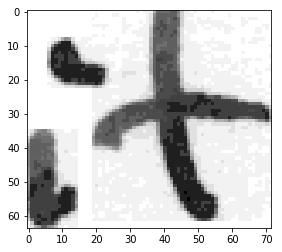

In [5]:
randomImage = list(images)[rand]
filename = os.path.join(images[randomImage][0], randomImage)

img = mpimg.imread(filename)
plt.imshow(img, cmap="gray")

In [6]:
#check we've got the right word for this image
myword = images[randomImage][1]
myword

'it'

## Characteristics of image

In order to build the classifier there are various attributes associated with the image that we will need to know:  
* the actual word of the image, which we will then map to a categorical variable
* the size of the image, so words are longer than others so will take up more space.  However, our NN will take a specific dimension as its inputs therefore we will need to resize each image to this maximum size.  I will not stretch and distort the image using PILLOW, but add no-information padding around the original image to build up its size

In [7]:
# Here we have the dictiionary of images we created with its full (filename) name, its path and the true word 
# associated with the image 
list(images.items())[rand]

('p03-112-09-07.png', ['./data/p03/p03-112', 'it'])

In [8]:
# Here we have the image converted to a numpy array - something Keras can read and the dimension of the image
data = np.asarray( img, dtype="float32" )

print("The image has dimensions: {}".format(data.shape))
print("The image as a numpy array:\n {}".format(data[:5,:5]))

The image has dimensions: (64, 72)
The image as a numpy array:
 [[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]


Next we need to convert all the words into a single list - so we know how unique many words we have and their position in the list - which we will use to identify the word when its a categorical variable

In [9]:
wordlist = []
for w in list(images.items()):
    wordlist.append(w[1][1])
wordlist = list(set(wordlist))

print("My random word '{}' chosen above is at postion {} in the wordlist"\
      .format(wordlist[wordlist.index(myword)], wordlist.index(myword)))

My random word 'it' chosen above is at postion 1295 in the wordlist


## Words class

I'm going make a Class to handle each word since each they have identical associated properties e.g. size.  

The Words class below keeps track of the number of words added to the class (wordCount), and the size of the word with biggest dimensions (maxSize).  This later variable will be used to resize the images later 

In [10]:
class Words():
    
    import numpy as np
    
    wordCount = 0
    maxSize = [0, 0]
    
    def __init__(self, name, path, word, wordIndex, size, data):
            self.name = name
            self.path = path
            self.word = word
            self.wordIndex = wordIndex
            self.original_size = size
            self.size = list(size)
            self.data = data
            self.flattern = []
            
            Words.wordCount += 1
            
            if self.size[0] > Words.maxSize[0]:
                Words.maxSize[0] = self.size[0]
            if self.size[1] > Words.maxSize[1]:
                Words.maxSize[1] = self.size[1]


    def resize(self, new_size=maxSize):
        
        if new_size[1] > self.size[1]:
        
            noOfCols =  new_size[1] - self.size[1]
            #Adding cols at the beginning 
            self.data = np.c_[ np.ones( (self.size[0],noOfCols//2) ), self.data ]
            #Adding remaining cols at the end
            self.data = np.c_[ self.data, np.ones( (self.size[0], noOfCols - noOfCols//2) ) ]
            self.size[1] = new_size[1]
           
        if new_size[0] > self.size[0] :
            noOfRows = new_size[0] - self.size[0]
            #Adding rows at the beginning 
            self.data = np.r_[ np.ones( (noOfRows//2, self.size[1]) ), self.data ]
            #Adding remaining rows at the end
            self.data = np.r_[ self.data, np.ones( (noOfRows - noOfRows//2, self.size[1]) ) ]
            self.size[0] = new_size[0]

            
    def reset_size(self):
        noOfCols =  self.size[1] - self.original_size[1]
        #Taking cols from the beginning 
        self.data = self.data[ : , noOfCols//2 +1 : ]
        #Taking cols at the end
        self.data = self.data[ : , : - noOfCols//2 ]
        self.size[1] = self.original_size[1]

        noOfRows = self.size[0] - self.original_size[0]
        #Taking rows from the beginning 
        self.data = self.data[ noOfRows//2 +1 : , : ]
        #Taking the remaining rows from the end
        self.data = self.data[ : - noOfRows//2 , :]
        self.size[0] = self.original_size[0]


### Checking the class works  

Read in the image, test its properties.  Resize the image, then reset the image

In [11]:
#Enter a word to the class - I know this image relates to the word "very"
myWord = Words(name = list(images)[rand], 
               path=images[list(images)[rand]][0], 
               word=myword, 
               wordIndex=wordlist.index(myword),
               size=data.shape,
               data=data)

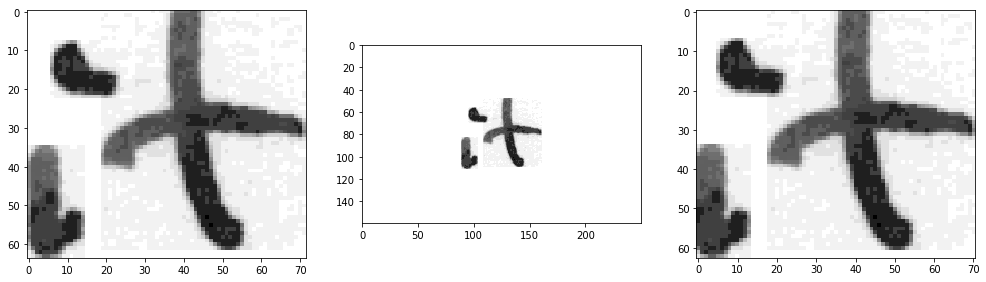

In [12]:
fig, ax = plt.subplots(1,3, figsize=(17,17))

#original size
ax[0].imshow(myWord.data, cmap="gray")

#resized
myWord.resize([160, 250])
ax[1].imshow(myWord.data, cmap="gray")

#reset
myWord.reset_size()
ax[2].imshow(myWord.data, cmap="gray")

plt.show()

In [ ]:
# Build the word objects

In [39]:
objs = list()

myWords = list(images)[:10]


wordlist = []
for w in list(myWords):
    wordlist.append(images[w][1])
wordlist = list(set(wordlist))



for word in myWords:
    filename = os.path.join(images[word][0], word)
    img = mpimg.imread(filename)
    
    objs.append(Words(name = images[word],  
                       path = images[word][0], 
                       word = images[word][1], 
                       wordIndex = wordlist.index(images[word][1]),
                       size = img.shape, 
                       data = np.asarray( img, dtype="float32" )
                      )
               )
    
for obj in objs:
    obj.resize()

In [40]:
X = objs[0].data
X = X[np.newaxis, ...]

y = []
y.append(objs[0].wordIndex)

for obj in objs[1:]:
    X_temp = obj.data[np.newaxis, ...]
    X = np.concatenate((X, X_temp), axis=0)
    y.append(obj.wordIndex)
y = np.asarray(y)

print(X.shape)
print(y)

(10, 122, 407)
[9 2 7 6 0 5 1 3 4 8]


In [41]:
# Train test split
from sklearn.model_selection import train_test_split

y_cat = to_categorical(y, y.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.33, random_state=42)

## Modelling

In [ ]:
## Model parameters

window_size = (12,12)
pool_size = (4,4)

In [ ]:
K.clear_session()

model = Sequential()

model.add(Conv2D(32, window_size, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, window_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))

model.add(Conv2D(64, window_size, activation='relu', padding='same'))
model.add(Conv2D(64, window_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(shape.y_cat[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=1, 
          validation_data=(X_test,y_test_cat), verbose=1,
          shuffle=True)

model.save('./model.h5')

### Assess the model

In [ ]:
model = load_model('./model.h5')
# make predictions
yhat = model.predict(X_test, verbose=0)
print(yhat)